In [6]:
import sys
import os
from IPython.display import Image, display

   
# Add the project root directory to Python's module search path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)
# import graph
from src.models.graph import GraphBuilder, decide_mood, START, END

# Usage example:
builder = GraphBuilder()

# Add nodes
builder.add_node("node_1", "This")
builder.add_node("node_2", "is")
builder.add_node("node_3", "really")
builder.add_node("node_4", "awesome")
builder.add_node("node_5", "bad")

# Add edges
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", "node_3")
builder.add_conditional_edge("node_3", decide_mood)
builder.add_edge("node_4", END)
builder.add_edge("node_5", END)

graph = builder.build()

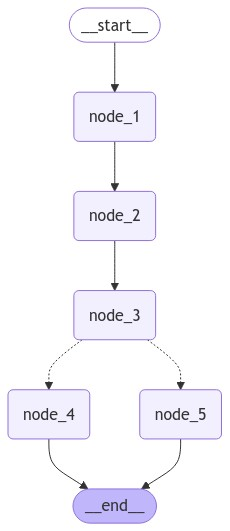

In [7]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
graph.invoke({"graph_state" : "Hi, this is Lance."})

------node_1------
------node_2------
------node_3------
------node_4------


{'graph_state': 'Hi, this is Lance. This is really awesome'}